In [165]:
%load_ext autoreload
%autoreload 2

import urllib.request as urllib2
from io import BytesIO
from zipfile import ZipFile
from IPython.display import display

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# loading in the data

This example uses the pulbic UCI [power consumption](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption) dataset.

This dataset withholds measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

In [2]:
zip_url: str = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
zipped_file_name: str = "household_power_consumption.txt"


df_power_consumption: pd.DataFrame = pd.read_csv(
    ZipFile(BytesIO(urllib2.urlopen(zip_url).read())).open(zipped_file_name),
    sep=";",
    parse_dates={"timestamp": ["Date", "Time"]},
    infer_datetime_format=True,
    low_memory=False,
    na_values=["nan", "?"],
    index_col="timestamp",
    dtype="float32",
)

display(df_power_consumption.sample(3))
df_power_consumption.info()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2007-08-13 05:29:00,0.140,0.000,235.050003,0.6,0.0,1.0,0.0
2008-03-10 02:51:00,1.378,0.000,244.500000,5.6,0.0,0.0,19.0
2010-06-16 00:29:00,0.844,0.186,242.070007,3.6,0.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float32
 1   Global_reactive_power  float32
 2   Voltage                float32
 3   Global_intensity       float32
 4   Sub_metering_1         float32
 5   Sub_metering_2         float32
 6   Sub_metering_3         float32
dtypes: float32(7)
memory usage: 71.2 MB


# EDA

## Some general data statistics

In [3]:
df_power_consumption.describe().round(2).astype("str")

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2049280.0,2049280.0,2049280.0,2049280.0,2049280.0,2049280.0,2049280.0
mean,1.09,0.12,240.84,4.63,1.12,1.3,6.46
std,1.06,0.11,3.24,4.44,6.15,5.82,8.44
min,0.08,0.0,223.2,0.2,0.0,0.0,0.0
25%,0.31,0.05,238.99,1.4,0.0,0.0,0.0
50%,0.6,0.1,241.01,2.6,0.0,0.0,1.0
75%,1.53,0.19,242.89,6.4,0.0,1.0,17.0
max,11.12,1.39,254.15,48.4,88.0,80.0,31.0


In [4]:
print(
    f'rows={df_power_consumption.shape[0]:,}', 
    f'cols={df_power_consumption.shape[1]:,}'
)
print('-'*80)
# It appears we have some NaN's (not a numbers) in the data.
print('NaN sum:')
df_power_consumption.isna().sum()

rows=2,075,259 cols=7
--------------------------------------------------------------------------------
NaN sum:


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [5]:
# so the data is actually regularly sampled
df_power_consumption.index.to_series().diff().value_counts()

0 days 00:01:00    2075258
Name: timestamp, dtype: int64

In [6]:
# but if we drop the nan's (i.e. the isnull() values), this will not be the case
df_power_consumption = df_power_consumption.dropna()
df_power_consumption.index.to_series().diff().value_counts().sample(3)

0 days 00:25:00          1
0 days 00:03:00         14
0 days 00:01:00    2049208
Name: timestamp, dtype: int64

In [7]:
df_power_consumption.sample(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2007-05-13 13:20:00,2.230,0.444,234.710007,10.0,1.0,4.0,17.0
2007-04-15 18:55:00,0.202,0.104,239.089996,1.0,0.0,0.0,0.0


## Visualizing all the data

**global variables**:
* `global_active_power`: household global **minute averaged** active power (kilowatt)
* `global_reactive_power`: household global **minute averaged** reactive power (kilowatt)
* `global_intensity`: household global **minute averaged** current (ampere)
* `voltage`: minute-averaged voltage (volt)

**sub meterings**:
* `sub_metering_1`: **kitchen** - dishwasher & microwave - (in watt-hour of **active energy**)
* `sub_metering_2`: **laundry room** - washing maching, tumble drier, refrigerator & light (in watt-hour of **active energy**)
* `sub_metering_3`: electric water-heater & air conditioner (in watt-hour of **active energy**)


As the user is only billed for the **active power**, we will use this variable as target.

In [8]:
corr = df_power_consumption.corr() * np.tril(
    np.ones(tuple([len(df_power_consumption.columns)] * 2)), k=-1
)
pd.set_option("precision", 3)
corr.style.background_gradient(cmap="coolwarm", axis=None)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,0.000,0.000,-0.000,0.000,0.000,0.000,0.000
Global_reactive_power,0.247,0.000,-0.000,0.000,0.000,0.000,0.000
Voltage,-0.400,-0.112,0.000,-0.000,-0.000,-0.000,-0.000
Global_intensity,0.999,0.266,-0.411,0.000,0.000,0.000,0.000
Sub_metering_1,0.484,0.123,-0.196,0.489,0.000,0.000,0.000
Sub_metering_2,0.435,0.139,-0.167,0.440,0.055,0.000,0.000
Sub_metering_3,0.639,0.090,-0.268,0.627,0.103,0.081,0.000


In [69]:
from plotly_resampler import FigureResampler
from plotly.subplots import make_subplots
import plotly.graph_objs as go

fig = FigureResampler(
    make_subplots(
        rows=3, cols=1, shared_xaxes=True,
        specs=[[{'secondary_y': True}], [{}], [{'secondary_y': True}]],
        subplot_titles=['Globals', 'Voltage', 'Sub metering']
    ),
    default_n_shown_samples=1000,
)

for c, row, visible in [('Global_active_power', 1, 1), ('Global_reaVoor de groepsraad deze zaterdag zullen er enkele flessen cava zijn van de laatkomers maar nog niet voldoende voor degenen die iets meer dorst hebben, wie drinkt al graag een glaasje meer?ctive_power', 1, 'legendonly'), ('Voltage', 2, 1),
    ('Sub_metering_1', 3, 1), ('Sub_metering_2', 3, 1), ('Sub_metering_3', 3, 1)]:
    fig.add_trace(
        go.Scattergl(name=c, visible=visible),
        hf_x=df_power_consumption.index,
        hf_y=df_power_consumption[c],
        row=row,
        col=1
    )

for c in ['Global_intensity']:
    fig.add_trace(
        go.Scattergl(name=c, visible='legendonly'),
        hf_x=df_power_consumption.index,
        hf_y=df_power_consumption[c],
        secondary_y=True,
        row=1,
        col=1
    )

# add a shaded weekend region on the lowest row
datelist = pd.date_range(df_power_consumption.index[0].date(), df_power_consumption.index[-1], freq='D')
weekend = datelist.weekday.isin([5, 6]).astype(int)
fig.add_trace(
    go.Scattergl(line_shape='hv', name='Weekend', showlegend=False, line_color ='rgba(0,0,0,0)', fillcolor='rgba(99, 110, 250, 0.15)', fill='tozeroy'),
    hf_x=datelist,
    hf_y=weekend,
    limit_to_view=True,
    max_n_samples=len(weekend),
    secondary_y=True,
    row=3,
    col=1
)


fig.update_layout(height=800)
fig.show_dash(mode='external', port=8050)

Dash app running on http://127.0.0.1:8050/


/home/jonas/git/gIDLab/predict/time_series/venv/lib/python3.9/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



Our objective is:
> To estimate the average `Global active power` over the last 15 minutes by **only** using past sub-metering values.

`TODO` decide whether global intensity will be used<br>
**remark**:
We explicitly did not use global variables (like `global_intensity`) as these are show high correlations with the global power consumption.

In [70]:
# Our client wants to know the average power consumption per 15 minutes and this
# 5 minutes in advance
avg_window_min = 15
shift_min = - (5 + avg_window_min)

avg_col = f"GAP_avg{avg_window_min}min"
target_col = f"{avg_col}_shift{shift_min}min"

# create the target by (1) calculating hte average and (2) shifting the data so we will forecast
df_power_consumption[avg_col] = df_power_consumption.rolling(avg_window_min, center=True)["Global_active_power"].aggregate(np.nanmean)
df_power_consumption[target_col] = df_power_consumption[avg_col].shift(shift_min)

 ### 🚨 Perform visual inspection 🔍

In [71]:
from plotly_resampler import FigureResampler
from plotly.subplots import make_subplots
import plotly.graph_objs as go

fig = FigureResampler(make_subplots(rows=1, cols=1, shared_xaxes=True))

for c, row, visible in [('Global_active_power', 1, 1), (avg_col, 1, 'legendonly'), (target_col, 1, 1)]:
    fig.add_trace(
        go.Scattergl(name=c, visible=visible),
        hf_x=df_power_consumption.index,
        hf_y=df_power_consumption[c],
        row=row,
        col=1
    )

fig.update_layout(height=400)
fig.show_dash(mode='external', port=8051)

Dash app running on http://127.0.0.1:8051/


/home/jonas/git/gIDLab/predict/time_series/venv/lib/python3.9/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



# ML time

## train-test split

In [72]:
train_columns = [f"Sub_metering_{i}" for i in range(1, 4)] + ["timestamp", "Global_intensity", "Voltage"]
target_col = target_col

# The percentage of data used for testing
test_pct = 0.2
day_margin = 3

# add the timestamp col
df_power_consumption["timestamp"] = df_power_consumption.index

# Temporal split: Use the last test_pct of the data as test_data
df_train = df_power_consumption[: -int(len(df_power_consumption) * test_pct)].copy()
X_train, y_train = df_train[train_columns], df_train[target_col]

df_test = df_power_consumption[df_train.index[-1] + pd.Timedelta(days=day_margin) :]
X_test, y_test = df_test[train_columns], df_test[target_col]

In [73]:
import sys
sys.path.append("../")

In [74]:
import scipy.stats as ss

from tsflex.chunking import chunk_data
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.utils import make_robust

## Feature extraction with tsflex

In [75]:
# !pip install holidays
import holidays

In [76]:
# some feature functions
def slope(x): return (x[-1] - x[0]) / x[0] if x[0] else 0
def abs_diff_mean(x): return np.mean(np.abs(x[1:] - x[:-1])) if len(x) > 1 else 0
def diff_std(x): return np.std(x[1:] - x[:-1]) if len(x) > 1 else 0


# time based features
def time_float(x) -> float:
    x_ = pd.Timestamp(x[-1])
    return np.float32(x_.hour + x_.minute / 60)

def day_of_week(x) -> int: return pd.Timestamp(x[-1]).day_of_week

def is_holiday(x) -> bool: return pd.Timestamp(x[-1]) in holidays.France()

def yesterday_holiday(x) -> bool:
    return (pd.Timestamp(x[-1]) - pd.Timedelta(days=1)) in holidays.France()

def tomorrow_holiday(x) -> bool:
    return (pd.Timestamp(x[-1]) - pd.Timedelta(days=1)) in holidays.France()

funcs = [
    make_robust(f)
    for f in [ np.min, np.max, np.std, np.mean, slope, ss.skew, abs_diff_mean, diff_std,sum, len,]
]
time_funcs = [
    make_robust(f)
    for f in [time_float, day_of_week, is_holiday, yesterday_holiday, tomorrow_holiday]
]

# Create the feature collection
fc = FeatureCollection(
    feature_descriptors=[
        MultipleFeatureDescriptors(
            functions=funcs,
            # TODO -> maybe also use the `intensity`
            series_names=list(set(train_columns).difference({"timestamp"})),
            windows=["15min", "30min", "1h", "6h", "12h", "24h"],
            strides="15min",
        ),
        MultipleFeatureDescriptors(
            functions=time_funcs,
            series_names="timestamp",
            windows=["15min"],
            strides="15min",
        ),
    ]
)

### Chunking train data

In [77]:
# %%time
# chunk the data in blocks of `max_chunk_dur`
# also omits the gaps :)
chunks = chunk_data(
    data=df_train,
    max_chunk_dur="365 days",
    chunk_range_margin="10 min",
    sub_chunk_overlap="15min",
)

we will now use these yearly chunks to extract the features

In [78]:
df_train_feats = pd.concat(
    [
        fc.calculate(chunk, show_progress=True, return_df=True, approve_sparsity=True)
        for chunk in chunks
    ]
)

100%|██████████| 305/305 [00:06<00:00, 46.88it/s]


In [79]:
df_train_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 110060 entries, 2006-12-16 17:39:00 to 2010-02-05 04:17:00
Columns: 305 entries, Global_intensity__abs_diff_mean__w=12h_s=15m to timestamp__yesterday_holiday__w=15m_s=15m
dtypes: float64(305)
memory usage: 256.9 MB


In [80]:
df_train_feats.sample(2)

,Global_intensity__abs_diff_mean__w=12h_s=15m,Global_intensity__abs_diff_mean__w=15m_s=15m,Global_intensity__abs_diff_mean__w=1D_s=15m,Global_intensity__abs_diff_mean__w=1h_s=15m,Global_intensity__abs_diff_mean__w=30m_s=15m,Global_intensity__abs_diff_mean__w=6h_s=15m,Global_intensity__amax__w=12h_s=15m,Global_intensity__amax__w=15m_s=15m,Global_intensity__amax__w=1D_s=15m,Global_intensity__amax__w=1h_s=15m,Global_intensity__amax__w=30m_s=15m,Global_intensity__amax__w=6h_s=15m,Global_intensity__amin__w=12h_s=15m,Global_intensity__amin__w=15m_s=15m,Global_intensity__amin__w=1D_s=15m,Global_intensity__amin__w=1h_s=15m,Global_intensity__amin__w=30m_s=15m,Global_intensity__amin__w=6h_s=15m,Global_intensity__diff_std__w=12h_s=15m,Global_intensity__diff_std__w=15m_s=15m,Global_intensity__diff_std__w=1D_s=15m,Global_intensity__diff_std__w=1h_s=15m,Global_intensity__diff_std__w=30m_s=15m,Global_intensity__diff_std__w=6h_s=15m,Global_intensity__len__w=12h_s=15m,Global_intensity__len__w=15m_s=15m,Global_intensity__len__w=1D_s=15m,Global_intensity__len__w=1h_s=15m,Global_intensity__len__w=30m_s=15m,Global_intensity__len__w=6h_s=15m,Global_intensity__mean__w=12h_s=15m,Global_intensity__mean__w=15m_s=15m,Global_intensity__mean__w=1D_s=15m,Global_intensity__mean__w=1h_s=15m,Global_intensity__mean__w=30m_s=15m,Global_intensity__mean__w=6h_s=15m,Global_intensity__skew__w=12h_s=15m,Global_intensity__skew__w=15m_s=15m,Global_intensity__skew__w=1D_s=15m,Global_intensity__skew__w=1h_s=15m,Global_intensity__skew__w=30m_s=15m,Global_intensity__skew__w=6h_s=15m,Global_intensity__slope__w=12h_s=15m,Global_intensity__slope__w=15m_s=15m,Global_intensity__slope__w=1D_s=15m,Global_intensity__slope__w=1h_s=15m,Global_intensity__slope__w=30m_s=15m,Global_intensity__slope__w=6h_s=15m,Global_intensity__std__w=12h_s=15m,Global_intensity__std__w=15m_s=15m,Global_intensity__std__w=1D_s=15m,Global_intensity__std__w=1h_s=15m,Global_intensity__std__w=30m_s=15m,Global_intensity__std__w=6h_s=15m,Global_intensity__sum__w=12h_s=15m,Global_intensity__sum__w=15m_s=15m,Global_intensity__sum__w=1D_s=15m,Global_intensity__sum__w=1h_s=15m,Global_intensity__sum__w=30m_s=15m,Global_intensity__sum__w=6h_s=15m,Sub_metering_1__abs_diff_mean__w=12h_s=15m,Sub_metering_1__abs_diff_mean__w=15m_s=15m,Sub_metering_1__abs_diff_mean__w=1D_s=15m,Sub_metering_1__abs_diff_mean__w=1h_s=15m,Sub_metering_1__abs_diff_mean__w=30m_s=15m,Sub_metering_1__abs_diff_mean__w=6h_s=15m,Sub_metering_1__amax__w=12h_s=15m,Sub_metering_1__amax__w=15m_s=15m,Sub_metering_1__amax__w=1D_s=15m,Sub_metering_1__amax__w=1h_s=15m,Sub_metering_1__amax__w=30m_s=15m,Sub_metering_1__amax__w=6h_s=15m,Sub_metering_1__amin__w=12h_s=15m,Sub_metering_1__amin__w=15m_s=15m,Sub_metering_1__amin__w=1D_s=15m,Sub_metering_1__amin__w=1h_s=15m,Sub_metering_1__amin__w=30m_s=15m,Sub_metering_1__amin__w=6h_s=15m,Sub_metering_1__diff_std__w=12h_s=15m,Sub_metering_1__diff_std__w=15m_s=15m,Sub_metering_1__diff_std__w=1D_s=15m,Sub_metering_1__diff_std__w=1h_s=15m,Sub_metering_1__diff_std__w=30m_s=15m,Sub_metering_1__diff_std__w=6h_s=15m,Sub_metering_1__len__w=12h_s=15m,Sub_metering_1__len__w=15m_s=15m,Sub_metering_1__len__w=1D_s=15m,Sub_metering_1__len__w=1h_s=15m,Sub_metering_1__len__w=30m_s=15m,Sub_metering_1__len__w=6h_s=15m,Sub_metering_1__mean__w=12h_s=15m,Sub_metering_1__mean__w=15m_s=15m,Sub_metering_1__mean__w=1D_s=15m,Sub_metering_1__mean__w=1h_s=15m,Sub_metering_1__mean__w=30m_s=15m,Sub_metering_1__mean__w=6h_s=15m,Sub_metering_1__skew__w=12h_s=15m,Sub_metering_1__skew__w=15m_s=15m,Sub_metering_1__skew__w=1D_s=15m,Sub_metering_1__skew__w=1h_s=15m,Sub_metering_1__skew__w=30m_s=15m,Sub_metering_1__skew__w=6h_s=15m,Sub_metering_1__slope__w=12h_s=15m,Sub_metering_1__slope__w=15m_s=15m,Sub_metering_1__slope__w=1D_s=15m,Sub_metering_1__slope__w=1h_s=15m,Sub_metering_1__slope__w=30m_s=15m,Sub_metering_1__slope__w=6h_s=15m,Sub_metering_1__std__w=12h_s=15m,Sub_metering_1__std__w=15m_s=15m,Sub_metering_1__std__w=1D_s=15m,Sub_metering_1__std

In [81]:
# make sure that there are no duplicate indices
print(df_train_feats.shape)
df_train_feats = df_train_feats[~df_train_feats.index.duplicated()]
print(df_train_feats.shape)

(110060, 305)
(110060, 305)


## Constructing the pipeline

In [83]:
selected_cols = df_train_feats.columns
df_train = df_train_feats.join(y_train)
# drop the observations of which we don't have the target
df_train = df_train[df_train[y_train.name].notna()]

In [84]:
# !pip install catboost
import catboost

In [93]:
pipe = catboost.CatBoostRegressor(verbose=100, )

# as this is a lot of data, this might take a minute or 5
pipe.fit(df_train[selected_cols], df_train[y_train.name])

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.085956
0:	learn: 0.9779436	total: 46.2ms	remaining: 46.2s
100:	learn: 0.5733681	total: 3.76s	remaining: 33.5s
200:	learn: 0.5505559	total: 7.37s	remaining: 29.3s
300:	learn: 0.5366180	total: 11s	remaining: 25.6s
400:	learn: 0.5254156	total: 14.7s	remaining: 22s
500:	learn: 0.5154548	total: 18.7s	remaining: 18.6s
600:	learn: 0.5065499	total: 22.5s	remaining: 14.9s
700:	learn: 0.4986305	total: 26.3s	remaining: 11.2s
800:	learn: 0.4921914	total: 30.4s	remaining: 7.54s
900:	learn: 0.4852471	total: 35.1s	remaining: 3.85s
999:	learn: 0.4788641	total: 39.4s	remaining: 0us


---

## Prediction on `df_test`

In [86]:
df_test_feats = fc.calculate(
    df_test, show_progress=True, return_df=True, approve_sparsity=True
)

100%|██████████| 305/305 [00:35<00:00,  8.57it/s]


In [87]:
df_test_tot = df_test_feats.join(y_test)

In [88]:
out = pipe.predict(df_test_tot[selected_cols])
df_test_tot["predictions"] = out

In [96]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [114]:
df_train_feats_ = df_train_feats.join(y_train)
train_predictions = pipe.predict(df_train_feats_[selected_cols])
nan_mask = df_train_feats_[y_train.name].notna()
y_true, y_pred = df_train_feats_[y_train.name][nan_mask], train_predictions[nan_mask]

print("MSE  [TRAIN]: ", round(mean_squared_error(y_true, y_pred), 3))
print("MAE  [TRAIN]: ", round(mean_absolute_error(y_true, y_pred), 3))
print("MAPE [TRAIN]: ", round(mean_absolute_percentage_error(y_true, y_pred), 3))
print("R2   [TRAIN]: ", round(r2_score(y_true, y_pred), 3))

MSE  [TRAIN]:  0.229
MAE  [TRAIN]:  0.298
MAPE [TRAIN]:  0.402
R2   [TRAIN]:  0.782


In [116]:
nan_mask = df_test_tot[y_test.name].notna()
y_true, y_pred = df_test_tot[nan_mask][y_test.name], df_test_tot[nan_mask]["predictions"]

print("MSE  [TEST]: ", round(mean_squared_error(y_true, y_pred), 3))
print("MAE  [TEST]: ", round(mean_absolute_error(y_true, y_pred), 3))
print("MAPE [TEST]: ", round(mean_absolute_percentage_error(y_true, y_pred), 3))
print("R2   [TEST]: ", round(r2_score(y_true, y_pred), 3))

MSE  [TEST]:  0.232
MAE  [TEST]:  0.308
MAPE [TEST]:  0.426
R2   [TEST]:  0.664


## Shap

In [106]:
# !pip install shap

In [107]:
import shap

In [117]:
import matplotlib.pyplot as plt

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


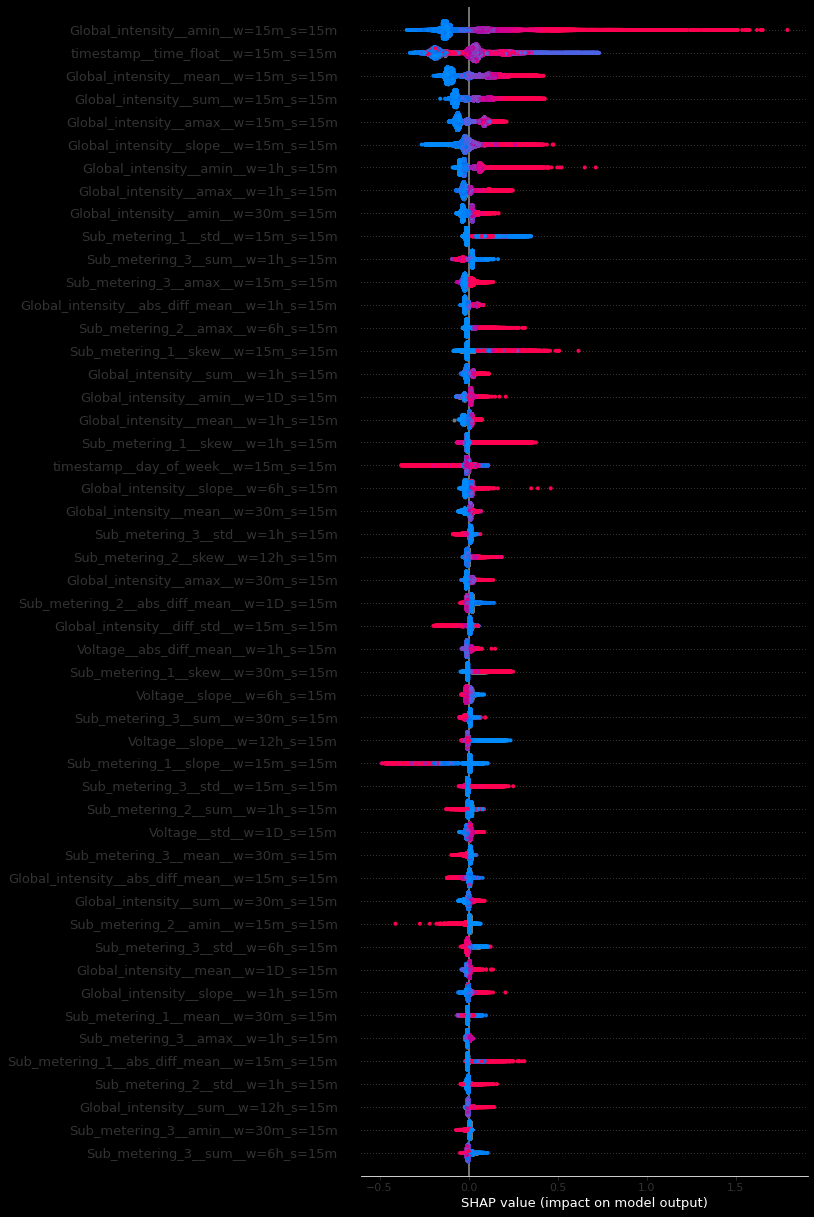

In [118]:
plt.figure()
explainer = shap.TreeExplainer(pipe)
shap_values = explainer.shap_values(df_train_feats[selected_cols])
shap.summary_plot(shap_values, df_train_feats[selected_cols], max_display=50, 
                    auto_size_plot=True, show=False, color_bar=False)
plt.show()

In [125]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(selected_cols, vals)),columns=['col_name','feature_importance_vals'])
feature_importance = feature_importance.sort_values(by=['feature_importance_vals'],ascending=False).reset_index(drop=True)
feature_importance.head()

,col_name,feature_importance_vals
0,Global_intensity__amin__w=15m_s=15m,0.157
1,timestamp__time_float__w=15m_s=15m,0.123
2,Global_intensity__mean__w=15m_s=15m,0.104
3,Global_intensity__sum__w=15m_s=15m,0.082
4,Global_intensity__amax__w=15m_s=15m,0.065


In [217]:
n = 50
important_cols = feature_importance[:n]['col_name'].values

In [203]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

In [204]:
df_train_feats.shape

(110060, 305)

In [205]:
gmm_pipe = Pipeline([
    ('scaler', PowerTransformer()),
    ('gmm', GaussianMixture(n_components=25, covariance_type='diag', random_state=42)),
])

In [206]:
gmm_pipe.fit(df_train_feats[important_cols].dropna(how='any'))

Pipeline(steps=[('scaler', PowerTransformer()),
                ('gmm',
                 GaussianMixture(covariance_type='diag', n_components=25,
                                 random_state=42))])

In [216]:
Voor de groepsraad deze zaterdag zullen er enkele flessen cava zijn van de laatkomers maar nog niet voldoende voor degenen die iets meer dorst hebben, wie drinkt al graag een glaasje meer?# loglh = gmm_pipe.score_samples(df_test_feats[important_cols].dropna(how='any'))
# loglh = pd.Series(index=df_test_feats[important_cols].dropna(how='any').index, data=loglh)

# AE = (df_test_tot['predictions'] - df_test_tot[y_test.name]).abs()

# from scipy.stats import pearsonr

# joined = AE.rename('MAE').to_frame().join((loglh * -1).rename('loglh')).dropna(how='any')
# pearsonr(joined.MAE, joined.loglh)

## Visualizing predictions

In [215]:
import plotly.graph_objects as go

fig = FigureResampler(make_subplots(rows=2, shared_xaxes=True, specs=[[{}], [{'secondary_y': True}]]), default_n_shown_samples=1000)

fig.add_trace(
    go.Scattergl(name='target'),
    hf_x=y_test.index, hf_y=y_test, row=1, col=1
)

fig.add_trace(
    go.Scattergl(name="predictions", marker_color="red"),
    hf_x=df_test_tot.index, hf_y=df_test_tot.predictions, row=1, col=1
)

fig.add_trace(
    go.Scattergl(name=f"GAP_shift{shift_min}min", visible='legendonly'),
    hf_x=df_test.index, hf_y=df_test['Global_active_power'].shift(shift_min),
    row=2, col=1
)

# fig.add_trace(
#     go.Scattergl(name=f"MAE"), hf_x=AE.index, hf_y=AE, row=2, col=1
# )

# fig.add_trace(
#     go.Scattergl(name='neg-loglh'),
#     hf_x=loglh.index, hf_y=loglh * -1, secondary_y=True, row=2, col=1
# )



# also visualize the lower and upper bounds; 
#   these values are the predictions +/- std, respectively

# fig.add_trace(
#     go.Scatter(
#         x=df_test_tot.index[:size],
#         y=df_test_tot.predictions[:size] + df_test_tot["std"][:size],
#         name="upper_bound",
#         showlegend=False,
#         marker_color='black',
#         line=dict(width=0),
#         mode='lines',
#     ),
# )

# fig.add_trace(
#     go.Scatter(
#         x=df_test_tot.index[:size],
#         y=df_test_tot.predictions[:size] - df_test_tot["std"][:size],
#         name="lower bound",
#         showlegend=False,
#         marker_color='black',
#         line=dict(width=0),
#         mode='lines',
#         fillcolor='rgba(255, 0, 0, 0.2)',
#         fill='tonexty'
#     ),
# )


fig.update_layout(title="Power consumption predictions", title_x=0.5, hovermode='x')
fig.update_xaxes(title="Time")
fig.update_yaxes(title="AVG power consumption (kW)")
# fig.update_layout(height=600)
fig.show_dash(mode='inline', height=700)

# Next step -> going to production

In [94]:
fc.serialize('fc.pkl')